In [6]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [7]:
water_kinematic_viscosity = 0.0000001
water_density = 1000
centreboard_area = 0.5  # [m^2]
centreboard_chord = 0.5  # [m]
centreboard_span = centreboard_area / centreboard_chord  # [m]
centreboard_aspect_ratio = centreboard_span / centreboard_chord
sail_area = 6.2


90.0
90.0
0.9999977
9.869605 15.5042925


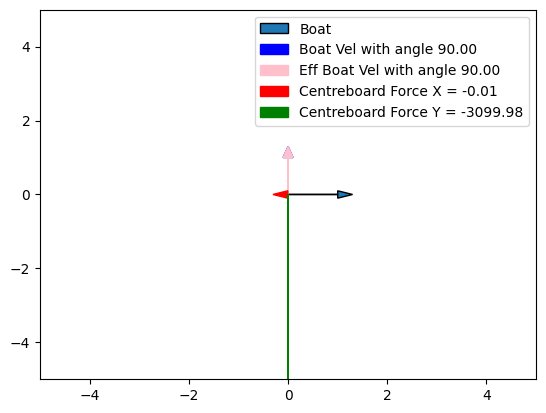

In [20]:
boat_dir = jnp.array((1.0, 0.0))
boat_vel = jnp.array((0.0,
                      1.0))
boat_speed = jnp.sqrt(boat_vel[0] ** 2 + boat_vel[1] ** 2)
eff_leeway_angle = leeway_angle = jnp.arctan2(boat_vel[1], boat_vel[0])
eff_leeway_angle = jnp.where(leeway_angle < -jnp.pi / 2, jnp.pi + leeway_angle, eff_leeway_angle)
eff_leeway_angle = jnp.where(leeway_angle > jnp.pi / 2, -jnp.pi + leeway_angle, eff_leeway_angle)
print(jnp.degrees(leeway_angle))
print(jnp.degrees(eff_leeway_angle))

pressure = 0.5 * water_density * boat_speed ** 2

hydro_friction = jax.lax.select(boat_speed != 0,
                                2.66 / jnp.sqrt((boat_speed * centreboard_chord) / water_kinematic_viscosity),
                                0.0)

separation = 1 - jnp.exp(-((jnp.abs(eff_leeway_angle)) / (jnp.pi / 180 * 25)) ** 2)
print(separation)

coeff_lift = 2 * jnp.pi * eff_leeway_angle
coeff_drag = hydro_friction + ((coeff_lift ** 2 * separation) / (jnp.pi * centreboard_aspect_ratio))
print(coeff_lift, coeff_drag)

separated_force_y = -jnp.sign(leeway_angle) * pressure * sail_area * jnp.sin(leeway_angle) ** 2

centreboard_lift = pressure * centreboard_area * coeff_lift
centreboard_drag = pressure * centreboard_area * coeff_drag

centreboard_force_x = (1 - separation) * (-centreboard_lift * jnp.sin(leeway_angle) - centreboard_drag * jnp.cos(leeway_angle))
centreboard_force_y = (1 - separation) * (centreboard_drag * jnp.sin(leeway_angle) - centreboard_lift * jnp.cos(leeway_angle)) + separation * separated_force_y
# centreboard_force_x = (1 - separation) * (tmp * jnp.cos(leeway_angle) + 2 * jnp.pi * eff_leeway_angle * jnp.sin(leeway_angle)) * pressure * centreboard_area
# centreboard_force_y = (1 - separation) * (tmp * jnp.sin(leeway_angle) - 2 * jnp.pi * eff_leeway_angle * jnp.cos(leeway_angle)) * pressure * centreboard_area + separation * separated_transverse_force

rotation_matrix = jnp.array([[jnp.cos(leeway_angle), -jnp.sin(leeway_angle)],
                             [jnp.sin(leeway_angle), jnp.cos(leeway_angle)]])
leeway_vec = rotation_matrix.dot(boat_dir)

rotation_matrix = jnp.array([[jnp.cos(eff_leeway_angle), -jnp.sin(eff_leeway_angle)],
                             [jnp.sin(eff_leeway_angle), jnp.cos(eff_leeway_angle)]])
eff_leeway_vec = rotation_matrix.dot(boat_dir)

plt.arrow(0, 0, boat_dir[0], boat_dir[1], head_width=0.2, label="Boat")
# plt.arrow(0, 0, boat_vel[0], boat_vel[1], head_width=0.2, color="Yellow", label="Boat Vel")
plt.arrow(0, 0, leeway_vec[0], leeway_vec[1], head_width=0.2, color="Blue", label=f"Boat Vel with angle {jnp.degrees(leeway_angle):.2f}")
plt.arrow(0, 0, eff_leeway_vec[0], eff_leeway_vec[1], head_width=0.2, color="Pink", label=f"Eff Boat Vel with angle {jnp.degrees(eff_leeway_angle):.2f}")
plt.arrow(0, 0, centreboard_force_x * jnp.sign(boat_dir[0]), 0, head_width=0.2, color="Red", label=f"Centreboard Force X = {centreboard_force_x:.2f}")
plt.arrow(0, 0, 0, centreboard_force_y, head_width=0.2, color="Green", label=f"Centreboard Force Y = {centreboard_force_y:.2f}")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.show()